In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


REQUIRED PACKAGES


In [2]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import keras
from keras.utils import plot_model
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,load_model,model_from_json
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras import backend as bK
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import optimizers

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pydotplus as pyd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

DATA LOADER


In [28]:
df = pd.read_csv("data/tweets-en.csv")
df = df.rename({'Text':'text'},axis=1)
df = df.dropna()

df_train = df.iloc[:320000]
df_test = df.iloc[320000:360000]
df_cv = df.iloc[360000:400000]

X_train = df_train[df_train.columns[:-1]]
y_train = df_train[df_train.columns[-1]]

X_test = df_test[df_test.columns[:-1]]
y_test = df_test[df_test.columns[-1]]

X_cv = df_cv[df_cv.columns[:-1]]
y_cv = df_cv[df_cv.columns[-1]]

In [29]:
print(df.info())

print(y_train.value_counts())
print(y_test.value_counts())
print(y_cv.value_counts())
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1010773 non-null  object
 1   Label   1010773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 23.1+ MB
None
0    175274
1    144726
Name: Label, dtype: int64
0    20800
1    19200
Name: Label, dtype: int64
1    20439
0    19561
Name: Label, dtype: int64
(320000, 1) (320000,)
(40000, 1) (40000,)
(40000, 1) (40000,)


PREPROCESSING STEPS

In [30]:
#Creating text tokenizer so that all data have same length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["text"].values)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

X_train_encoded = tokenizer.texts_to_sequences(X_train["text"])
X_test_encoded = tokenizer.texts_to_sequences(X_test["text"])
X_cv_encoded = tokenizer.texts_to_sequences(X_cv["text"])

lengths = []
for encoded_tweet in X_train_encoded:
    lengths.append(len(encoded_tweet))
max_length = max(lengths)
print(max_length)
print(np.percentile(lengths,99.9))

96813
2222
67.0


In [31]:
#Creating padded sequences
encoding_length = 140

X_train_padded = pad_sequences(X_train_encoded, maxlen=encoding_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=encoding_length, padding='post')
X_cv_padded = pad_sequences(X_cv_encoded, maxlen=encoding_length,padding='post')

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)

In [ ]:
#Creating a embedding vector of each word in vocabulary from pretrained vectors

# w2v_model = KeyedVectors.load_word2vec_format('/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)
# embedding_matrix_w2v = np.zeros((vocab_size, 300))
# for word, i in tkn.word_index.items():
#     try:
#         embedding_vector = w2v_model[word]
#     except:
#         embedding_vector = [0]*300
    
#     if embedding_vector is not None:
#         embedding_matrix_w2v[i] = embedding_vector
        
# embedding_matrix_w2v.shape

In [8]:
embeddings = pd.read_csv("/data_mining_sarcasm_detection/embeddings/embeddings_w2v")
embeddings.drop(embeddings.columns[0],axis=1,inplace=True)
embedding_matrix_w2v = embeddings.to_numpy()

Model Metric Functions

In [13]:
def precision_md(y_true, y_pred):
        true_positives = bK.sum(bK.round(bK.clip(y_true * y_pred, 0, 1)))
        predicted_positives = bK.sum(bK.round(bK.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + bK.epsilon())
        return precision

def recall_md(y_true, y_pred):
        true_positives = bK.sum(bK.round(bK.clip(y_true * y_pred, 0, 1)))
        possible_positives = bK.sum(bK.round(bK.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + bK.epsilon())
        return recall

def f1_md(y_true, y_pred):
    precision = precision_md(y_true, y_pred)
    recall = recall_md(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+ bK.epsilon()))

## Model 1: Baseline

In [ ]:
#Creating callbacks
tensor_board = TensorBoard(log_dir="baseline")

check_point = ModelCheckpoint("baseline_model.h5", 
                               monitor="val_f1_md", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

early_stop = EarlyStopping(monitor = 'val_f1_md', 
                            min_delta = 0, 
                            patience =32,
                            verbose=1,
                            restore_best_weights=True)

In [ ]:
#Model Architecture

input_data = Input(shape=(140,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv1_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
maxp_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(maxp_1)
maxp_2 = MaxPooling1D(pool_size=2)(conv1_2)
flatten_ = Flatten()(maxp_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten_)
output = Dense(2, activation='softmax')(dense)

baseline_model = Model(inputs=[input_data], outputs=[output])

print(baseline_model.summary())

In [ ]:
baseline_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[f1_md,'acc'])

history_baseline = baseline_model.fit(X_train_padded, y_train, 
               batch_size=64, 
               epochs=10, 
               verbose=1,
               callbacks=[tensor_board,check_point,early_stop],
               validation_data=(X_cv_padded, y_cv))

In [ ]:
baseline_score = baseline_model.evaluate(X_test_padded, y_test)
print(baseline_score)

393/393 [==============================] - 3s 7ms/step - loss: 0.0032 - acc: 0.9997
[0.0032197802793234587, 0.9996815919876099]


[[6721    0]
 [   4 5837]]


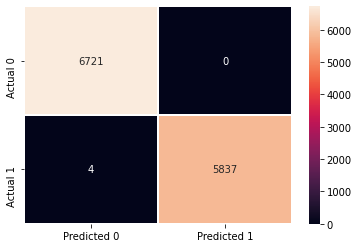

In [ ]:
con_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(baseline_model.predict(X_test_padded), axis=1))

print(con_mat)
sns.heatmap(con_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

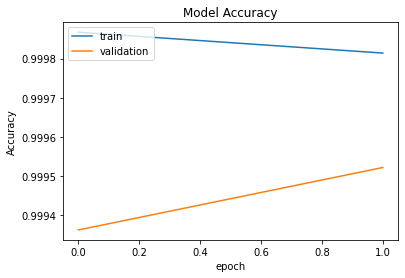

In [ ]:
plt.plot(history_baseline.history['f1_md'][1:])
plt.plot(history_baseline.history['val_f1_md'][1:])
plt.title('Model Metric')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

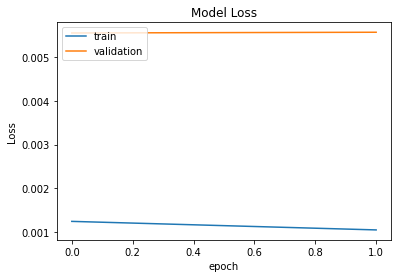

In [ ]:
plt.plot(history_baseline.history['loss'][1:])
plt.plot(history_baseline.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

## Model 2: Baseline + Sentiments

In [ ]:
#Loading the pretrained sentiment model and sentiment tokenizer

with open("json_senti.json","r") as json_file:
  loaded_model_json = json_file.read()
sentiment_model = model_from_json(loaded_model_json)
sentiment_model.load_weights("model_senti.h5")

with open("sentiment_tokenizer.p","rb") as pickle_file:
  sentiment_tokenizer = pickle.load(pickle_file)

In [ ]:
#Calculating the intermediate outputs from sentiment model

X_train_encoded = sentiment_tokenizer.texts_to_sequences(X_train["text"])
X_test_encoded = sentiment_tokenizer.texts_to_sequences(X_test["text"])
X_cv_encoded = sentiment_tokenizer.texts_to_sequences(X_cv["text"])

X_train_padded = pad_sequences(X_train_encoded, maxlen=encoding_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=encoding_length, padding='post')
X_cv_padded = pad_sequences(X_cv_encoded, maxlen=encoding_length, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_sentiment = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train = intermediate_layer_sentiment.predict(X_train_padded)
intermediate_output_test = intermediate_layer_sentiment.predict(X_test_padded)
intermediate_output_cv = intermediate_layer_sentiment.predict(X_cv_padded)

print(intermediate_output_train.shape)

(320000, 100)


In [ ]:
X_train_2 = [X_train_padded, np.array(intermediate_output_train)]
X_test_2 = [X_test_padded, np.array(intermediate_output_test)]
X_cv_2 = [X_cv_padded, np.array(intermediate_output_cv)]

In [ ]:
#Creating callbacks

tensor_board = TensorBoard(log_dir="base_senti")

check_point = ModelCheckpoint("base_senti.h5", 
                               monitor="val_f1_md", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

early_stop = EarlyStopping(monitor = 'val_f1_md', 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1,
                            restore_best_weights=True)

In [ ]:
#Model Architecture

input_data = Input(shape=(encoding_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv1_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
maxp_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(maxp_1)
maxp_2 = MaxPooling1D(pool_size=2)(conv1_2)
flatten_ = Flatten()(maxp_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten_)

input_senti = Input(shape=(100,), name='sentiment_input')
concat = concatenate([dense, input_senti])
output = Dense(2, activation='softmax')(concat)

base_senti = Model(inputs=[input_data, input_senti], outputs=[output])

print(base_senti.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 140, 300)     29043900    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 137, 50)      60050       embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 68, 50)       0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
base_senti.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[f1_md,'acc'])

h_base_senti = base_senti.fit(X_train_2, y_train, 
               batch_size=64, 
               epochs=15, 
               verbose=1, callbacks=[tensor_board, check_point, early_stop], 
               validation_data=(X_cv_2, y_cv))

Epoch 1/15
5000/5000 [==============================] - 66s 13ms/step - loss: 0.6338 - f1_md: 0.6352 - acc: 0.6352 - val_loss: 0.5968 - val_f1_md: 0.6676 - val_acc: 0.6676

Epoch 00001: val_f1_md improved from -inf to 0.66760, saving model to base_senti.h5
Epoch 2/15
5000/5000 [==============================] - 62s 12ms/step - loss: 0.5777 - f1_md: 0.6948 - acc: 0.6948 - val_loss: 0.5909 - val_f1_md: 0.6769 - val_acc: 0.6769

Epoch 00002: val_f1_md improved from 0.66760 to 0.67692, saving model to base_senti.h5
Epoch 3/15
5000/5000 [==============================] - 61s 12ms/step - loss: 0.5560 - f1_md: 0.7130 - acc: 0.7130 - val_loss: 0.6013 - val_f1_md: 0.6708 - val_acc: 0.6708

Epoch 00003: val_f1_md did not improve from 0.67692
Epoch 4/15
5000/5000 [==============================] - 62s 12ms/step - loss: 0.5410 - f1_md: 0.7242 - acc: 0.7242 - val_loss: 0.6046 - val_f1_md: 0.6718 - val_acc: 0.6718

Epoch 00004: val_f1_md did not improve from 0.67692
Epoch 5/15
5000/5000 [===========

In [ ]:
base_senti_score = base_senti.evaluate(X_test_2, y_test)
print(base_senti.metrics_names)
print(base_senti_score)

1250/1250 [==============================] - 8s 7ms/step - loss: 0.6021 - f1_md: 0.6713 - acc: 0.6713
['loss', 'f1_md', 'acc']
[0.602084219455719, 0.671299934387207, 0.6712999939918518]


[[15135  5665]
 [ 7483 11717]]


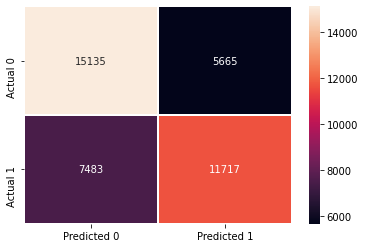

In [ ]:
con_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(base_senti.predict(X_test_2), axis=1))

print(con_mat)
sns.heatmap(con_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

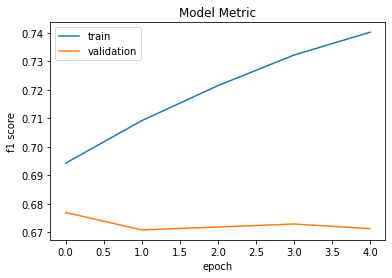

In [ ]:
plt.plot(h_base_senti.history['f1_md'][1:])
plt.plot(h_base_senti.history['val_f1_md'][1:])
plt.title('Model Metric')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

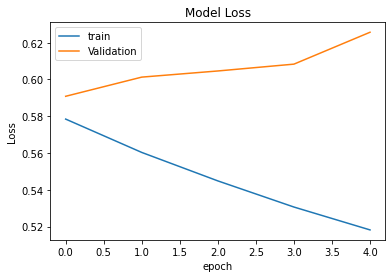

In [ ]:
plt.plot(h_base_senti.history['loss'][1:])
plt.plot(h_base_senti.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
#Storing the model
base_senti_json = base_senti.to_json()
with open("/models/base_senti.json","w") as json_file:
  json_file.write(base_senti_json)

base_senti.save_weights("/models/base_senti.h5")
print("saved model to disk")

saved model to disk


## Model 3: Baseline + Emotion

In [ ]:
#Loading the pretrained emotion model and emotion tokenizer

with open("json_emo.json","r") as json_file:
  loaded_model_json = json_file.read()
emotion_model = model_from_json(loaded_model_json)
emotion_model.load_weights("model_emo.h5")

with open("emotion_tokenizer.p","rb") as pickle_file:
  emotion_tokenizer = pickle.load(pickle_file)

In [15]:
#Calculate feature representations from emotion model

X_train_encoded = emotion_tokenizer.texts_to_sequences(X_train["text"])
X_test_encoded = emotion_tokenizer.texts_to_sequences(X_test["text"])
X_cv_encoded = emotion_tokenizer.texts_to_sequences(X_cv["text"])

X_train_padded = pad_sequences(X_train_encoded, maxlen=300, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=300, padding='post')
X_cv_padded = pad_sequences(X_cv_encoded, maxlen=300, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_padded)
intermediate_output_test = intermediate_layer_model.predict(X_test_padded)
intermediate_output_cv = intermediate_layer_model.predict(X_cv_padded)

print(intermediate_output_train.shape)

(320000, 150)


In [16]:
#Final Input
X_train_3 = [X_train_padded, np.array(intermediate_output_train)]
X_test_3 = [X_test_padded, np.array(intermediate_output_test)]
X_cv_3 = [X_cv_padded, np.array(intermediate_output_cv)]

In [17]:
#Creating callbacks

tensor_board = TensorBoard(log_dir="base_emo")

check_point = ModelCheckpoint("base_emo.h5", 
                               monitor="val_f1_md", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

early_stop = EarlyStopping(monitor = 'val_f1_md', 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1,
                            restore_best_weights=True)



In [18]:
#Baseline + Emotion Model Architecture

input_data = Input(shape=(300,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv1_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
maxp_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(maxp_1)
maxp_2 = MaxPooling1D(pool_size=2)(conv1_2)
flatt_ = Flatten()(maxp_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatt_)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])
output = Dense(2, activation='softmax')(concat)

base_emo = Model(inputs=[input_data, input_emo], outputs=[output])

print(base_emo.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     29043900    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 297, 50)      60050       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 148, 50)      0           conv1d[0][0]                     
____________________________________________________________________________________________

In [19]:
base_emo.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[f1_md,'acc'])

h_base_emo = base_emo.fit(X_train_3, y_train, 
               batch_size=64, 
               epochs=15, 
               verbose=1, callbacks=[tensor_board, check_point, early_stop], 
               validation_data=(X_cv_3, y_cv))

Epoch 1/15
5000/5000 [==============================] - 61s 12ms/step - loss: 0.6337 - f1_md: 0.6342 - acc: 0.6342 - val_loss: 0.6007 - val_f1_md: 0.6685 - val_acc: 0.6685

Epoch 00001: val_f1_md improved from -inf to 0.66850, saving model to base_emo.h5
Epoch 2/15
5000/5000 [==============================] - 58s 12ms/step - loss: 0.5773 - f1_md: 0.6975 - acc: 0.6975 - val_loss: 0.6181 - val_f1_md: 0.6570 - val_acc: 0.6571

Epoch 00002: val_f1_md did not improve from 0.66850
Epoch 3/15
5000/5000 [==============================] - 58s 12ms/step - loss: 0.5526 - f1_md: 0.7165 - acc: 0.7165 - val_loss: 0.5989 - val_f1_md: 0.6736 - val_acc: 0.6736

Epoch 00003: val_f1_md improved from 0.66850 to 0.67360, saving model to base_emo.h5
Epoch 4/15
5000/5000 [==============================] - 58s 12ms/step - loss: 0.5326 - f1_md: 0.7325 - acc: 0.7325 - val_loss: 0.5962 - val_f1_md: 0.6791 - val_acc: 0.6791

Epoch 00004: val_f1_md improved from 0.67360 to 0.67910, saving model to base_emo.h5
Epoc

In [22]:
base_emo_score = base_emo.evaluate(X_test_3, y_test)
print(base_emo.metrics_names)
print(base_emo_score)

1250/1250 [==============================] - 7s 5ms/step - loss: 0.6142 - f1_md: 0.6661 - acc: 0.6661
['loss', 'f1_md', 'acc']
[0.6142296195030212, 0.6660999655723572, 0.666100025177002]


[[17754  3046]
 [10268  8932]]


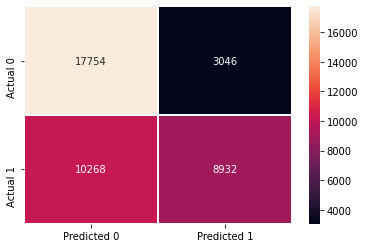

In [ ]:
con_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(base_emo.predict(X_test_3), axis=1))

print(con_mat)
sns.heatmap(con_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

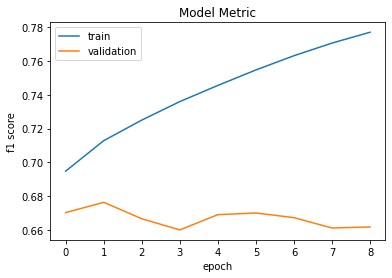

In [ ]:
plt.plot(h_base_emo.history['f1_md'][1:])
plt.plot(h_base_emo.history['val_f1_md'][1:])
plt.title('Model Metric')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

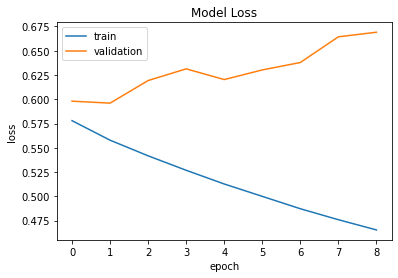

In [ ]:
plt.plot(h_base_emo.history['loss'][1:])
plt.plot(h_base_emo.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [23]:
base_emo_json = base_emo.to_json()
with open("/models/base_emo.json","w") as json_file:
  json_file.write(base_emo_json)

base_emo.save_weights("/models/base_emo.h5")
print("saved model to disk")

saved model to disk


## Model 4: Baseline + Sentiment + Emotion

In [ ]:
#Loading the pretrained sentiment model and sentiment tokenizer

with open("json_senti.json","r") as json_file:
  loaded_model_json = json_file.read()
sentiment_model = model_from_json(loaded_model_json)
sentiment_model.load_weights("model_senti.h5")

with open("sentiment_tokenizer.p","rb") as pickle_file:
  sentiment_tokenizer = pickle.load(pickle_file)

In [32]:
#Calculating the feature representations from sentiment model

X_train_encoded = sentiment_tokenizer.texts_to_sequences(X_train["text"])
X_test_encoded = sentiment_tokenizer.texts_to_sequences(X_test["text"])
X_cv_encoded = sentiment_tokenizer.texts_to_sequences(X_cv["text"])

X_train_padded = pad_sequences(X_train_encoded, maxlen=encoding_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=encoding_length, padding='post')
X_cv_padded = pad_sequences(X_cv_encoded, maxlen=encoding_length, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_sentiment = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_sentiment.predict(X_train_padded)
intermediate_output_test_1 = intermediate_layer_sentiment.predict(X_test_padded)
intermediate_output_cv_1 = intermediate_layer_sentiment.predict(X_cv_padded)

In [ ]:
#Loading the pretrained emotion model and emotion tokenizer

with open("json_emo.json","r") as json_file:
  loaded_model_json = json_file.read()
emotion_model = model_from_json(loaded_model_json)
emotion_model.load_weights("model_emo.h5")

with open("emotion_tokenizer.p","rb") as pickle_file:
  emotion_tokenizer = pickle.load(pickle_file)

In [33]:
#Calculating the intermediate outputs from emotion model

X_train_encoded = emotion_tokenizer.texts_to_sequences(X_train["text"])
X_test_encoded = emotion_tokenizer.texts_to_sequences(X_test["text"])
X_cv_encoded = emotion_tokenizer.texts_to_sequences(X_cv["text"])

X_train_padded = pad_sequences(X_train_encoded, maxlen=300, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=300, padding='post')
X_cv_padded = pad_sequences(X_cv_encoded, maxlen=300, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(X_train_padded)
intermediate_output_test_2 = intermediate_layer_model.predict(X_test_padded)
intermediate_output_cv_2 = intermediate_layer_model.predict(X_cv_padded)

In [34]:
#Final input to model
X_train_4 = [X_train_padded, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_test_4 = [X_test_padded, np.array(intermediate_output_test_1),np.array(intermediate_output_test_2)]
X_cv_4 = [X_cv_padded, np.array(intermediate_output_cv_1),np.array(intermediate_output_cv_2)]

In [35]:
#Creating callbacks

tensor_board = TensorBoard(log_dir="base_senti_emo")

check_point = ModelCheckpoint("base_senti_emo.h5", 
                               monitor="val_f1_md", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

early_stop = EarlyStopping(monitor = 'val_f1_md', 
                            min_delta = 0, 
                            patience = 3,
                            verbose=1,
                            restore_best_weights=True)

In [36]:
#Baseline + Sentiment + Emotion Model Architecture

input_data = Input(shape=(300,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv1_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
maxP_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(maxP_1)
maxP_2 = MaxPooling1D(pool_size=2)(conv1_2)
flatt_ = Flatten()(maxP_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatt_)

input_senti = Input(shape=(100,), name='sentiment_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_senti, input_emo])

output = Dense(2, activation='softmax')(concat)

base_senti_emo = Model(inputs=[input_data, input_senti, input_emo], outputs=[output])

print(base_senti_emo.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     29043900    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 297, 50)      60050       embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 148, 50)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [37]:
base_senti_emo.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[f1_md,'acc'])

h_base_senti_emo = base_senti_emo.fit(X_train_4, y_train, 
               batch_size=64, 
               epochs=10, 
               verbose=1, callbacks=[tensor_board, check_point, early_stop], 
               validation_data=(X_cv_4, y_cv))

Epoch 1/10
5000/5000 [==============================] - 57s 11ms/step - loss: 0.6452 - f1_md: 0.6212 - acc: 0.6212 - val_loss: 0.6042 - val_f1_md: 0.6620 - val_acc: 0.6620

Epoch 00001: val_f1_md improved from -inf to 0.66200, saving model to base_senti_emo.h5
Epoch 2/10
5000/5000 [==============================] - 57s 11ms/step - loss: 0.5829 - f1_md: 0.6903 - acc: 0.6903 - val_loss: 0.6033 - val_f1_md: 0.6664 - val_acc: 0.6665

Epoch 00002: val_f1_md improved from 0.66200 to 0.66645, saving model to base_senti_emo.h5
Epoch 3/10
5000/5000 [==============================] - 58s 12ms/step - loss: 0.5574 - f1_md: 0.7124 - acc: 0.7124 - val_loss: 0.5922 - val_f1_md: 0.6750 - val_acc: 0.6750

Epoch 00003: val_f1_md improved from 0.66645 to 0.67500, saving model to base_senti_emo.h5
Epoch 4/10
5000/5000 [==============================] - 57s 11ms/step - loss: 0.5377 - f1_md: 0.7270 - acc: 0.7270 - val_loss: 0.6105 - val_f1_md: 0.6707 - val_acc: 0.6708

Epoch 00004: val_f1_md did not improve

In [38]:
base_senti_emo_score = base_senti_emo.evaluate(X_test_4, y_test)
print(base_senti_emo.metrics_names)
print(base_senti_emo_score)

1250/1250 [==============================] - 8s 6ms/step - loss: 0.6016 - f1_md: 0.6700 - acc: 0.6700
['loss', 'f1_md', 'acc']
[0.6015772819519043, 0.6699999570846558, 0.6700000166893005]


[[16319  4481]
 [ 8710 10490]]


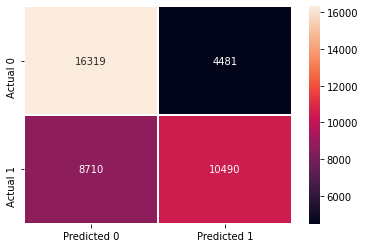

In [ ]:
con_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(base_senti_emo.predict(X_test_4), axis=1))

print(con_mat)
sns.heatmap(con_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

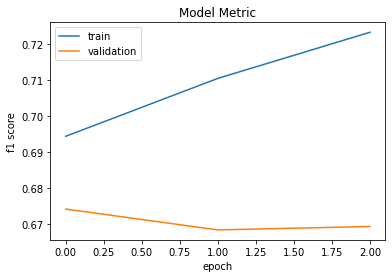

In [ ]:
plt.plot(h_base_senti_emo.history['f1_md'][1:])
plt.plot(h_base_senti_emo.history['val_f1_md'][1:])
plt.title('Model Metric')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

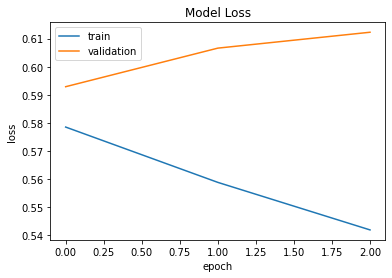

In [ ]:
plt.plot(h_base_senti_emo.history['loss'][1:])
plt.plot(h_base_senti_emo.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [39]:
#Storing the model

base_senti_emo_json = base_senti_emo.to_json()
with open("/models/base_senti_emo.json","w") as json_file:
  json_file.write(base_senti_emo_json)

base_emo.save_weights("/models/base_senti_emo.h5")
print("saved model to disk")

saved model to disk
